# Experiment 1.  The fraction of the disappearance time analysis (Fig. 2A-D).

In [2]:
# importing prerequisites and constants
import os
import pandas as pd
import numpy as np
from scipy.stats import sem, wilcoxon
import matplotlib.pyplot as plt
import matplotlib
import pymc as pm
%matplotlib inline

### Importing raw results and computing subjective states and their corresponding duration

In [26]:
### loading raw results and computing subjective states and their corresponding durations
results= pd.read_csv(os.path.join('Experiment 1', 'Experiment1_Main.csv'), sep=';')
subjective_state_change= pd.DataFrame(columns= ['ID', 'Block', 'BlockDuration', 'Aligned', 
                                                'MasksN',  'Trial', 'TargetCount', 'Time', 'Duration'])
for current_ID in results.ID.unique():
    print('Observer %s'%(current_ID), end=': blocks ')
    for current_block in range(5, 9): # first four blocks were training only
        print('%d'%(current_block), end=' ')
        iBlockTrials= results[(results.ID==current_ID) & (results.Block==current_block)].index
        
        # block constants
        current_entry= {'ID': current_ID, 
                        'Block': current_block, 
                        'BlockDuration': results.Duration[iBlockTrials[0]],  
                        'Aligned': results.Aligned[iBlockTrials[0]], 
                        'MasksN': results.MasksN[iBlockTrials[0]]}
        
        # adding an onset state - all visibile
        current_entry['Trial']= 0
        current_entry['TargetCount']= 3
        current_entry['Duration']= 0
        current_entry['Time']= 0
        subjective_state_change.loc[subjective_state_change.shape[0]] = pd.Series(current_entry)
        
        CurrentTargetCount= 3
        PrevioiusEventTime= 0
        # going through events
        for iTrial, iRow in enumerate(iBlockTrials):
            current_entry['Trial']= iTrial+1
            if results.Event[iRow]==0:
                CurrentTargetCount-= 1
            else:
                CurrentTargetCount+= 1
            current_entry['TargetCount']= CurrentTargetCount
            current_entry['Time']=  results.Time[iRow]/1000.0
            subjective_state_change.set_value(len(subjective_state_change)-1, 
                                              'Duration', 
                                              results.Time[iRow]/1000.0-PrevioiusEventTime)
            if iTrial==len(iBlockTrials)-1: # the last trial
                current_entry['Duration']= current_entry['BlockDuration']-results.Time[iRow]/1000.0
            PrevioiusEventTime= results.Time[iRow]/1000.0
            subjective_state_change.loc[subjective_state_change.shape[0]] = pd.Series(current_entry)
    print('\r', end='')

## Computing fraction of time then at least on target remained invisible (for each condition and observer)

The raw time fraction values are stored in **fraction_matrix**, the adjusted means (following Loftus & Masson (1994)) are stored in **adjusted_matrix**.

In [18]:
## computing fraction of time at least one target disappeared for each observer x condition
FractionOfTime= subjective_state_change.groupby(['ID', 'Aligned', 'MasksN']).apply(
    lambda x: pd.Series({
            'DisappearanceFraction': x[x.TargetCount<3].Duration.sum()/x.BlockDuration.values[0]
        })).reset_index()

## converting table to a matrix
FractionOfTime['MasksN']= FractionOfTime.MasksN.astype(int)
FractionOfTime['ConditionCode']= np.array(['M', 'A']).astype(str)[FractionOfTime.Aligned.astype(int)]+FractionOfTime.MasksN.astype(str)
matrix_like_df= FractionOfTime.pivot(index='ID', columns= 'ConditionCode', values='DisappearanceFraction').reset_index()
fraction_matrix= np.array(matrix_like_df)[:, 1:]

## Adjusting observers' means following Loftus & Masson (1994)
observer_average= np.mean(fraction_matrix, axis=1)
condition_average= np.mean(fraction_matrix, axis=0)
adjusted_matrix= fraction_matrix-np.tile(observer_average, (4, 1)).T+np.tile(np.mean(fraction_matrix), (observer_average.shape[0], 4))
adjusted_matrix= adjusted_matrix.astype(float) # making sure that type if correct
condition_labels= np.array(matrix_like_df.columns[1:])

### Using Bayesian approach to fit linear regression: 
1. Intercept + individual factors
2. Intercept + individual factors + **interaction**

In [19]:
# factors presence for each condition
Aligned= np.array([1, 1, 0, 0]) # alignment factor 
Mask= np.array([1, 0, 1, 0]) # mask factor

# data and data shape (for forming the fitted data)
data_shape= (adjusted_matrix.shape[0],1)
data=adjusted_matrix

# variance around the linear regressor
sigma = pm.Exponential('sigma', beta=1.) 

# regression parameters
intercept     = pm.Uniform('intercept', -1e20, 1e20, value=0.5)
factorAligned= pm.Uniform('factorAligned', -1e20, 1e20)
factorMask  = pm.Uniform('factorMask', -1e20, 1e20)
factorBoth= pm.Uniform('factorBoth', -1e20, 1e20)
 
@pm.deterministic(plot=False)
def linear_fit_interaction(intercept=intercept, factorAligned=factorAligned, factorMask=factorMask, factorBoth=factorBoth, Aligned=Aligned, Mask=Mask, data_shape=data_shape):
    return np.tile(intercept+factorAligned*Aligned+factorMask*Mask+factorBoth*(Aligned & Mask), data_shape)

@pm.deterministic(plot=False)
def linear_fit_factors(intercept=intercept, factorAligned=factorAligned, factorMask=factorMask, Aligned=Aligned, Mask=Mask, data_shape=data_shape):
    return np.tile(intercept+factorAligned*Aligned+factorMask*Mask, data_shape)

# defining models
yFactors = pm.Normal('yFactors', mu=linear_fit_factors, tau=1.0/sigma**2, value=adjusted_matrix, observed=True)
modelFactors = pm.Model([yFactors, sigma, intercept, factorAligned, factorMask])

yInteraction = pm.Normal('yInteraction', mu=linear_fit_interaction, tau=1.0/sigma**2, value=adjusted_matrix, observed=True)
modelInteraction = pm.Model([yInteraction, sigma, intercept, factorAligned, factorMask, factorBoth])
 
# running MCMCs
print('Independent factors:')                   
map_ = pm.MAP(modelFactors)
map_.fit()
mcmcFactors = pm.MCMC(modelFactors)
mcmcFactors.sample(120000, 100000, 2)
print()

print('Interaction:')                   
map_ = pm.MAP(modelInteraction)
map_.fit()
mcmcInteraction = pm.MCMC(modelInteraction)
mcmcInteraction.sample(120000, 100000, 2)                   
print()

Independent factors:
 [-----------------100%-----------------] 120000 of 120000 complete in 31.0 sec
Interaction:
 [-----------------100%-----------------] 120000 of 120000 complete in 36.8 sec


### Using fitted interaction model to predict values

In [20]:
### computing mean ± S.E.M. of predicted values for each condition

# getting posterior distributions for individual factors and their interaction  
InterceptDist= mcmcInteraction.trace('intercept')[:]
AlignedDist= mcmcInteraction.trace('factorAligned')[:]
MaskDist= mcmcInteraction.trace('factorMask')[:]
BothDist= mcmcInteraction.trace('factorBoth')[:]

# factors presence for each condition
Aligned= np.array([1, 1, 0, 0]) # alignment factor 
Mask= np.array([1, 0, 1, 0]) # mask factor

# preparing arrays
predicted_mean= np.zeros(Aligned.shape)
predicted_std= np.zeros(Aligned.shape)

# linear fit with an interaction term
def linear_fit_with_interaction(intercept, factorAligned, factorMask, factorBoth, Aligned, Mask):
    return intercept+factorAligned*Aligned+factorMask*Mask+factorBoth*(Aligned & Mask)
def linear_fit(intercept, factorAligned, factorMask,Aligned, Mask):
    return intercept+factorAligned*Aligned+factorMask*Mask

# computing distribution of predicted values for each condition
for iCond in range(len(Aligned)):
    current_condition_dist= linear_fit_with_interaction(InterceptDist, AlignedDist, MaskDist, BothDist, Aligned[iCond], Mask[iCond])
    predicted_mean[iCond]= np.mean(current_condition_dist)
    predicted_std[iCond]= np.std(current_condition_dist)

### Plotting the experimental results and model fits alongside with posterior distributions for individual factors and their combination (Fig. 2A-D in the manuscript).

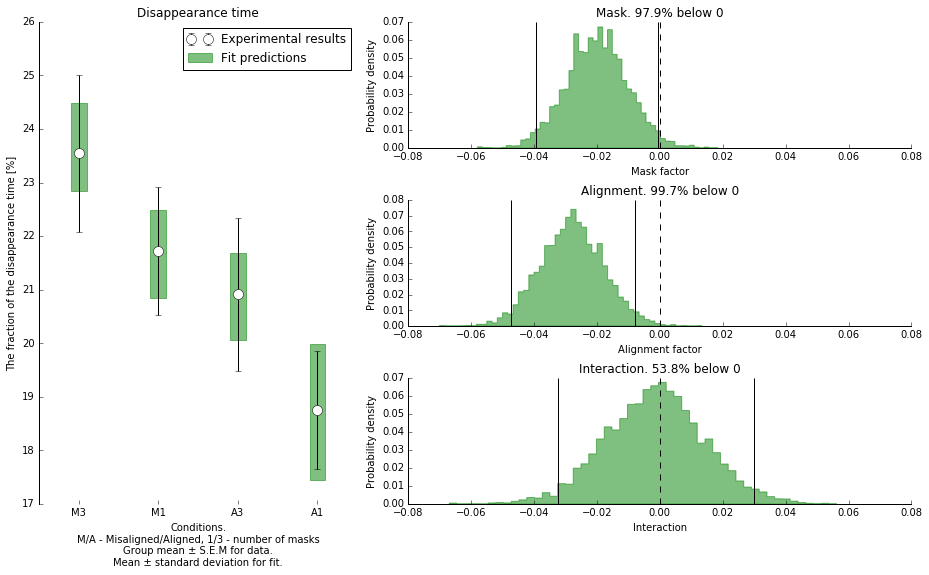

In [24]:
### plotting results
condition_order= [3, 2, 1, 0]

matplotlib.rcParams['figure.figsize'] = (13.0, 8.0)
ax= plt.subplot2grid((6,5), (0, 0), colspan=2, rowspan=6)
data_plot= plt.errorbar(condition_order, 
             np.mean(adjusted_matrix, axis=0)*100,
             yerr=sem(adjusted_matrix)*100,
             fmt= 'ko',
             markersize= 10,
             markerfacecolor = 'white')

for iCond in range(len(predicted_mean)):
    fit_plot= plt.fill_between(condition_order[iCond]+np.array([-0.1, 0.1]),
                     100*(predicted_mean[iCond]-predicted_std[iCond]+np.zeros((2, ))),
                     100*(predicted_mean[iCond]+predicted_std[iCond]+np.zeros((2, ))),
                     facecolor='green', edgecolor= 'green', alpha= 0.5)
                     
plt.xticks(condition_order, condition_labels)
current_axis= plt.axis()
plt.axis([-0.5, 3.5, current_axis[2], current_axis[3]])
plt.ylabel('The fraction of the disappearance time [%]')
plt.legend(handles= [data_plot, fit_plot], labels=['Experimental results', 'Fit predictions'])
plt.xlabel('Conditions.\nM/A - Misaligned/Aligned, 1/3 - number of masks\nGroup mean ± S.E.M for data.\nMean ± standard deviation for fit.')
plt.title('Disappearance time')

# Hide the right and top/bottom spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax= plt.subplot2grid((6,5), (0, 2), colspan=3, rowspan=2)
plt.hist(MaskDist, bins=50, histtype="stepfilled", weights=np.ones(MaskDist.shape)/MaskDist.shape[0], color='green', edgecolor='green', alpha=0.5)
current_axis= plt.axis()
plt.vlines(np.percentile(MaskDist, [2.5, 97.5]), 0, current_axis[3], color='black')
plt.vlines([0], 0, current_axis[3], color='black', linestyles=['dashed'])
plt.title('Mask. %.1f%% below 0'%(100*np.sum(MaskDist<0)/MaskDist.shape[0]))
plt.ylabel('Probability density')
plt.xlabel('Mask factor')
plt.axis([-0.08, 0.08, 0, current_axis[3]])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


ax= plt.subplot2grid((6,5), (2, 2), colspan=3, rowspan=2)
plt.hist(AlignedDist, bins=50, histtype="stepfilled", weights=np.ones(AlignedDist.shape)/AlignedDist.shape[0], color='green', edgecolor='green', alpha=0.5)
current_axis= plt.axis()
plt.vlines(np.percentile(AlignedDist, [2.5, 97.5]), 0, current_axis[3], color='black')
plt.vlines([0], 0, current_axis[3], color='black', linestyles=['dashed'])
plt.title('Alignment. %.1f%% below 0'%(100*np.sum(AlignedDist<0)/AlignedDist.shape[0]))
plt.axis([-0.08, 0.08, 0, current_axis[3]])
plt.ylabel('Probability density')
plt.xlabel('Alignment factor')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


ax= plt.subplot2grid((6,5), (4, 2), colspan=3, rowspan=2)
plt.hist(BothDist, bins=50, histtype="stepfilled", weights=np.ones(BothDist.shape)/BothDist.shape[0], color='green', edgecolor='green', alpha=0.5)
current_axis= plt.axis()
plt.vlines(np.percentile(BothDist, [2.5, 97.5]), 0, current_axis[3], color='black')
plt.vlines([0], 0, current_axis[3], color='black', linestyles=['dashed'])
plt.ylabel('Probability density')
plt.xlabel('Interaction')
plt.title('Interaction. %.1f%% below 0'%(100*np.sum(BothDist<0)/BothDist.shape[0]))
plt.axis([-0.08, 0.08, 0, current_axis[3]])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.tight_layout()
plt.show()